In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

In [ ]:
!unrar x '/content/gdrive/MyDrive/Project_ML30/face_detection/images.rar' -d /content/Data/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/Project_ML30/face_detection/images.rar

Creating    /content/Data                                             OK
Creating    /content/Data/tung                                        OK
Extracting  /content/Data/tung/0_236_1632476680.8520656.png                0%  OK 
Extracting  /content/Data/tung/0_249_1632477899.7008057.png                0%  OK 
Extracting  /content/Data/tung/100_159_1632479433.7841876.png              0%  OK 
Extracting  /content/Data/tung/100_162_1632477352.1412237.png              0%  OK 
Extracting  /content/Data/tung/101_168_1632479437.2611892.png              0%  OK 
Extracting  /content/Data/tung/101_171_1632477355.8632228.png              0%  OK 
Extracting  /content/Data/tung/102_152_1632479440.7711928.png              0%  OK 
Extracting  /content/Data/tung/102_179_1632477359.4682326.png

In [54]:
import pathlib
data_dir = pathlib.Path('/content/Data')

In [55]:
# Save result on google drive
PROJECT = data_dir
RESULT = PROJECT/'Results'
SAVED_MODEL = RESULT/'Saved_model'
IMG_SIZE = 224 
BATCH_SIZE = 32

In [56]:
# Prepare ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.2)     
  
  val_gen = ImageDataGenerator(validation_split=0.2)  

  train_generator = train_gen.flow_from_directory(
                                data_dir,  
                                target_size=(IMG_SIZE, IMG_SIZE),  
                                batch_size=BATCH_SIZE,
                                class_mode='sparse',
                                shuffle=True,
                                seed=42,           
                                subset='training')  

  validation_generator = val_gen.flow_from_directory(
                                data_dir,
                                target_size=(IMG_SIZE, IMG_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='sparse',
                                shuffle=False,       
                                seed=42,              
                                subset='validation')  
  return train_generator, validation_generator

In [57]:
train_generator, validation_generator = generator_augmentation_maker()

Found 587 images belonging to 3 classes.
Found 146 images belonging to 3 classes.


In [58]:
# Build model
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

base_model = keras.applications.MobileNetV2(weights='imagenet',
                                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                   include_top=False)
# Freeze the base model's weights
base_model.trainable=False

In [59]:
from keras.applications.mobilenet_v2 import preprocess_input

def my_model():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))
  x = preprocess_input(inputs)
  
  x = base_model(x,training=False)

  x = layers.Dense(256)(x)
  x = layers.Dense(512)(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(512)(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(3, activation='softmax')(x)

  model = keras.Model(inputs, outputs)

  return model

In [60]:
model = my_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 7, 7, 256)         327936    
_________________________________________________________________
dense_13 (Dense)             (None, 7, 7, 512)         131584    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0   

In [61]:
model.compile(optimizer= 'Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

In [63]:
ear_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mod_chk = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Project_ML30/face_detection/face_detect.h5', monitor='val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)


In [64]:
hist = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks = [ear_stop, mod_chk, lr_rate], verbose=2)


Epoch 1/20
19/19 - 13s - loss: 1.2230 - accuracy: 0.8109 - val_loss: 0.0643 - val_accuracy: 0.9658


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
19/19 - 8s - loss: 0.1895 - accuracy: 0.9659 - val_loss: 0.0422 - val_accuracy: 0.9863
Epoch 3/20
19/19 - 8s - loss: 0.0677 - accuracy: 0.9761 - val_loss: 0.0548 - val_accuracy: 0.9863
Epoch 4/20
19/19 - 7s - loss: 0.0963 - accuracy: 0.9779 - val_loss: 0.0801 - val_accuracy: 0.9726
Epoch 5/20
19/19 - 8s - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0407 - val_accuracy: 0.9863
Epoch 6/20
19/19 - 8s - loss: 0.0592 - accuracy: 0.9779 - val_loss: 0.4278 - val_accuracy: 0.8904
Epoch 7/20
19/19 - 7s - loss: 0.1076 - accuracy: 0.9796 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 8/20
19/19 - 8s - loss: 0.0443 - accuracy: 0.9761 - val_loss: 0.0551 - val_accuracy: 0.9726
Epoch 9/20
19/19 - 8s - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0316 - val_accuracy: 0.9863
Epoch 10/20
19/19 - 7s - loss: 0.0430 - accuracy: 0.9898 - val_loss: 0.0188 - val_accuracy: 0.9863
Epoch 11/20
19/19 - 7s - loss: 0.0606 - accuracy: 0.9864 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 12/20
19/19 

In [65]:
acc = model.evaluate(train_generator, steps=len(validation_generator), verbose = 2)

5/5 - 2s - loss: 0.0223 - accuracy: 0.9937


In [66]:
# Save model
model.save('/content/gdrive/MyDrive/Project_ML30/face_detection/face_detect.h5') 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [77]:
# Save model
model.save('/content/gdrive/MyDrive/Project_ML30/face_detection/face_detect.pkl') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project_ML30/face_detection/face_detect.pkl/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [75]:
from pathlib import Path
import pickle

In [71]:
p = Path(data_dir)
all_paths = list(p.glob('**/*.png'))
all_labels = list(map(lambda x: str(x).split('/')[-2], all_paths))


In [72]:
label_dict = {}
for i, name in enumerate(set(all_labels)):
    label_dict[i] = name

label_dict

{0: 'long', 1: 'tung', 2: 'minh'}

In [73]:
a_file = open("labels.pkl", "wb")
pickle.dump(label_dict, a_file)
a_file.close()

In [78]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

In [ ]:
# up load file from google drive
from google.colab import files
uploaded = files.upload()

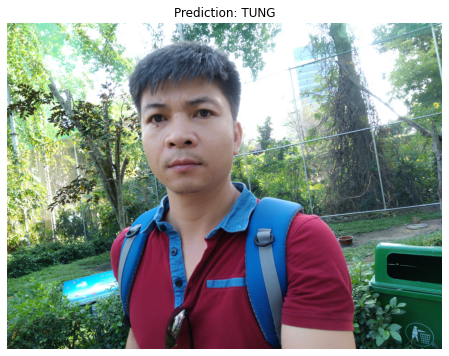

True

In [79]:
# Predict your file
image_path= '/content/C360_2019-02-06-15-53-03-159.jpg'
predict(model, image_path, IMG_SIZE)

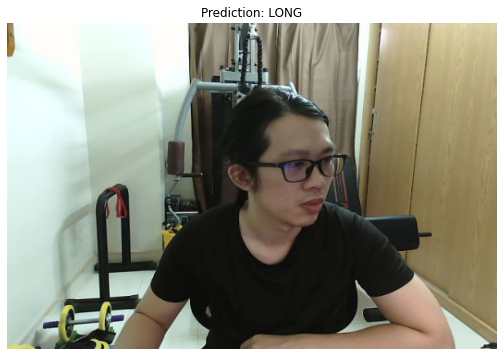

True

In [80]:
# Predict your file
image_path= '/content/1_528_1632390359.8684804.png'
predict(model, image_path, IMG_SIZE)